In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import gc
import pickle
%matplotlib inline

In [4]:
data = pd.read_csv("Workshop_Backtest.csv")

In [24]:
def sharpe_ratio(actualReturn, signals, return_stat=False, return_accumulate=False):
    if actualReturn.shape != signals.shape:
        raise AssertionError(f"Backtest shape {actualReturn.shape}, got {signals.shape}")
    dailyReturns = (actualReturn * signals)
    if len(dailyReturns.shape) > 1 and dailyReturns.shape[1] > 1:
        dailyReturns = dailyReturns.mean(axis=1)
    returns = [dailyReturns.mean() / dailyReturns.std() * np.sqrt(240)]
    if return_stat:
        returns.append(dailyReturns.mean())
        returns.append(dailyReturns.std())
    if return_accumulate:
        returns.append(dailyReturns.sum())
    return returns if len(returns) > 1 else returns[0]

In [6]:
actual_returns = data[data['datetime'] >= '2017/1/1'].iloc[:, 1:]

In [5]:
bt_index = actual_returns.iloc[0].name

In [102]:
bt_index

1699

In [5]:
data

,datetime,CF,SR,TA,al,au,c,cu,l,m,p,rb,ru,v,y,zn
0,2010/1/5,0.011700,0.010348,0.011220,0.048953,0.011921,0.012156,0.034943,0.005915,0.011528,0.012012,0.010009,0.028698,0.000648,0.010202,0.041029
1,2010/1/6,-0.024954,-0.035594,-0.031634,-0.043162,-0.016297,-0.009922,-0.028508,-0.033712,-0.030935,-0.040734,-0.033175,-0.010413,-0.019430,-0.033251,-0.038521
2,2010/1/7,0.006552,-0.029944,0.007801,0.009022,0.029701,0.015823,0.019672,0.006085,0.005376,0.006187,0.000446,0.018066,-0.004624,0.002293,0.002316
3,2010/1/8,0.003254,-0.000179,-0.007741,0.013691,-0.005040,-0.006231,-0.009486,-0.000806,-0.011698,-0.015651,0.001782,0.007605,-0.009954,-0.018302,-0.006932
4,2010/1/11,-0.025361,-0.007719,-0.013896,-0.049063,-0.026535,-0.014107,-0.037981,-0.050040,-0.029422,-0.037763,-0.020231,-0.027869,-0.022788,-0.031072,-0.046999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2021/6/23,0.000945,-0.002906,-0.002797,-0.004259,-0.001391,-0.001161,-0.003336,0.008197,-0.003260,-0.015468,-0.006221,0.006939,-0.013458,-0.012977,-0.001369
2786,2021/6/24,0.008816,0.008927,0.036859,0.018979,-0.000107,0.002713,0.002329,0.013759,0.010110,0.022112,0.028271,0.007657,0.013642,0.019102,0.002742
2787,2021/6/25,0.002809,0.000181,0.002318,-0.011280,-0.003323,0.007731,-0.005663,0.016039,0.013247,0.003985,0.006088,-0.003419,0.016969,-0.010224,-0.010255
2788,2021/6/28,0.000000,0.007222,-0.016962,0.000796,-0.014412,0.002301,-0.007886,-0.006072,0.007844,0.012759,-0.010346,-0.018300,0.001726,0.012051,0.006447


In [6]:
# requirement:
# get multi-dimensional data
# get include other column data
# get test data

In [7]:
X = data.iloc[:, 1:].values

In [72]:
class SequenceDataLoader:
    
    def __len__(self):
        for i in self.y.values():
            return i.shape[0] - 1
    
    def get_include_other(self, index, col_name):
        return self.X[index], self.y[col_name][index], self.X[index+1][-1].reshape(1, -1)
    
    def get_single(self, index, col_name):
        return self.X[col_name][index], self.y[col_name][index], self.X[col_name][index+1][-1].reshape(1, -1)
    
    def __init__(self, df, date_from, window_size, include_other):
        bt_index = df[df['datetime'] >= date_from].iloc[0].name - window_size - 1
        columns = len(df.columns) - 1

        if include_other:
            sample_shape = (window_size, columns)
            self.X = np.lib.stride_tricks.sliding_window_view(df.iloc[bt_index:, 1:].values, sample_shape, axis=(0,1)) # (nFeature, sFeature, sCol)
            self.X = self.X.reshape(-1, window_size, columns)
        else:
            self.X = {}
            for col in df.columns:
                self.X[col] = np.lib.stride_tricks.sliding_window_view(df[col].iloc[bt_index:].values, window_size) # (nWindow, sFeature)
                self.X[col] = self.X[col].reshape(-1, window_size, columns)
        self.y = {}
        for col in df.columns:
            self.y[col] = np.lib.stride_tricks.sliding_window_view(df[col].iloc[bt_index+1:].values, window_size)
            
        self.get = self.get_include_other if include_other else self.get_single

In [81]:
def evaluate_loader(estimator, dataLoader=None,  data=None, date_from = None, window_size = None, include_other=None):
    signal = np.zeros_like(actual_returns)
    if dataloader is None:
        dataLoader = SequenceDataLoader(data, date_from, window_size, include_other)
    for col_idx, col_name in enumerate(actual_returns.columns):
        col_signal = np.zeros((len(signal)))
        for i in range(len(dataLoader)):
            train_X, train_y, test_X = dataLoader.get(i, col_name)
            estimator.fit(train_X, train_y)
            col_signal[i] = estimator.predict(test_X)
        signal[:,col_idx] = col_signal
    signal = np.where(signal > 0, 1, -1)
    return sharpe_ratio(actual_returns, signal)

In [73]:
evaluate_loader(LinearRegression(n_jobs=-1), data, '2017/1/1', 1500, True)

1.8155104487733784

In [12]:
# param:
#   window size
#   feature size
#   include other?
#   L1, L2
perf = {}
date_from = '2017/1/1'
max_window_size = data[data['datetime'] >= date_from].iloc[0].name - 1
for window_size in tqdm(range(1450, 1551, 20), position=0, leave=False): # window_size
    perf[window_size] = {}
    for include_other in tqdm((True, False),position=1, leave=False):
        include_other_name = "T" if include_other else "F"
        perf[window_size][include_other_name] = evaluate_loader(LinearRegression(n_jobs=-1), data, date_from, window_size, 1, include_other)
        print(f"{window_size} {include_other} {perf[window_size][include_other_name]}")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1450 True 1.8431915499439744
1450 False 0.23924209221918769


  0%|          | 0/2 [00:00<?, ?it/s]

1470 True 1.9111789959830188
1470 False 0.32087885517896614


  0%|          | 0/2 [00:00<?, ?it/s]

1490 True 1.8015983120295591
1490 False 0.4728122816139446


  0%|          | 0/2 [00:00<?, ?it/s]

1510 True 1.7609439230831372
1510 False 0.5999575958313383


  0%|          | 0/2 [00:00<?, ?it/s]

1530 True 1.8069147859382395
1530 False 0.5757277097994494


  0%|          | 0/2 [00:00<?, ?it/s]

1550 True 1.8174215512195817
1550 False 0.5006005299622481


In [13]:
# param:
#   window size
#   feature size
#   include other?
#   L1, L2
#   
date_from = '2017/1/1'
max_window_size = data[data['datetime'] >= date_from].iloc[0].name - 1
for window_size in tqdm(range(1570, 1651, 20), position=0, leave=False): # window_size
    perf[window_size] = {}
    for include_other in tqdm((True, False),position=1, leave=False):
        include_other_name = "T" if include_other else "F"
        perf[window_size][include_other_name] = evaluate_loader(LinearRegression(n_jobs=-1), data, date_from, window_size, 1, include_other)
        print(f"{window_size} {include_other} {perf[window_size][include_other_name]}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1570 True 1.816347927897378
1570 False 0.6040802691556377


  0%|          | 0/2 [00:00<?, ?it/s]

1590 True 1.8256459156436848
1590 False 0.6740884657346597


  0%|          | 0/2 [00:00<?, ?it/s]

1610 True 1.7958792371448793
1610 False 0.7430503950304237


  0%|          | 0/2 [00:00<?, ?it/s]

1630 True 1.8345004077741558
1630 False 0.599672957521827


  0%|          | 0/2 [00:00<?, ?it/s]

1650 True 1.7271851699458476
1650 False 0.7174013208690313


In [74]:
print(perf)

{1450: {'T': 1.8431915499439744, 'F': 0.23924209221918769}, 1470: {'T': 1.9111789959830188, 'F': 0.32087885517896614}, 1490: {'T': 1.8015983120295591, 'F': 0.4728122816139446}, 1510: {'T': 1.7609439230831372, 'F': 0.5999575958313383}, 1530: {'T': 1.8069147859382395, 'F': 0.5757277097994494}, 1550: {'T': 1.8174215512195817, 'F': 0.5006005299622481}, 1570: {'T': 1.816347927897378, 'F': 0.6040802691556377}, 1590: {'T': 1.8256459156436848, 'F': 0.6740884657346597}, 1610: {'T': 1.7958792371448793, 'F': 0.7430503950304237}, 1630: {'T': 1.8345004077741558, 'F': 0.599672957521827}, 1650: {'T': 1.7271851699458476, 'F': 0.7174013208690313}}


In [75]:
best_windowsize = 1470

In [76]:
regularization = {}

In [77]:
for i in tqdm(range(0, 6)):
    c = 10 ** -i
    regularization[c] = {}
    regularization[c]["L1"] = evaluate_loader(Lasso(alpha=c),data, date_from, best_windowsize, True)
    regularization[c]["L2"] = evaluate_loader(Ridge(alpha=c),data, date_from, best_windowsize, True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [83]:
for i in tqdm(range(0, 6)):
    c = 1 + 10 ** -i
    regularization[c] = {}
    dataloader = SequenceDataLoader(data, date_from, best_windowsize, True)
    regularization[c]["L1"] = evaluate_loader(Lasso(alpha=c), dataLoader=dataloader)
    regularization[c]["L2"] = evaluate_loader(Ridge(alpha=c), dataLoader=dataloader)

  0%|          | 0/6 [00:00<?, ?it/s]

In [85]:
for i in tqdm(range(10)):
    c = 1 + 0.1 * i
    regularization[c] = {}
    dataloader = SequenceDataLoader(data, date_from, best_windowsize, True)
    regularization[c]["L1"] = evaluate_loader(Lasso(alpha=c), dataLoader=dataloader)
    regularization[c]["L2"] = evaluate_loader(Ridge(alpha=c), dataLoader=dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [86]:
sharpe_ratiolarization

{1: {'L1': 0.7362142379834234, 'L2': 2.013350766078257},
 0.1: {'L1': 0.7362142379834234, 'L2': 2.011566237894905},
 0.01: {'L1': 0.7362142379834234, 'L2': 1.8346442621011896},
 0.001: {'L1': 0.7362142379834234, 'L2': 1.8847141466829553},
 0.0001: {'L1': 0.7362142379834234, 'L2': 1.9187161020778374},
 1e-05: {'L1': 1.4095498969576274, 'L2': 1.9111789959830188},
 2: {'L1': 0.7362142379834234, 'L2': 1.7173484458689823},
 1.1: {'L1': 0.7362142379834234, 'L2': 2.147635477386883},
 1.01: {'L1': 0.7362142379834234, 'L2': 2.0628190948402114},
 1.001: {'L1': 0.7362142379834234, 'L2': 1.9984789148824846},
 1.0001: {'L1': 0.7362142379834234, 'L2': 2.013350766078257},
 1.00001: {'L1': 0.7362142379834234, 'L2': 2.013350766078257},
 1.2: {'L1': 0.7362142379834234, 'L2': 2.2111360832613816},
 1.3: {'L1': 0.7362142379834234, 'L2': 2.082875365345557},
 1.4: {'L1': 0.7362142379834234, 'L2': 2.0257495513782646},
 1.5: {'L1': 0.7362142379834234, 'L2': 1.9664307986816665},
 1.6: {'L1': 0.7362142379834234,

# ARMA

In [1]:
import statsmodels.api as sm
from itertools import product

In [7]:
col_eval = {}
for col_name in tqdm(actual_returns.columns):
    col_eval[col_name] = sm.tsa.arma_order_select_ic(data[col_name], ic=['aic','bic'],max_ar=4, max_ma=4)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/visu/anaconda3/envs/torch38/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/visu/anaconda3/envs/torch38/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/visu/anaconda3/envs/torch38/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/visu/anaconda3/envs/torch38/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/visu/anaconda3/env

In [8]:
for name, res in col_eval.items():
    print(f"{name}: AIC {res.aic_min_order} BIC {res.bic_min_order}")

CF: AIC (3, 2) BIC (0, 0)
SR: AIC (3, 4) BIC (0, 0)
TA: AIC (0, 0) BIC (0, 0)
al: AIC (0, 0) BIC (0, 0)
au: AIC (4, 0) BIC (0, 0)
c: AIC (0, 2) BIC (1, 0)
cu: AIC (0, 0) BIC (0, 0)
l: AIC (4, 0) BIC (0, 0)
m: AIC (1, 0) BIC (0, 0)
p: AIC (0, 2) BIC (0, 0)
rb: AIC (2, 4) BIC (0, 0)
ru: AIC (0, 2) BIC (0, 0)
v: AIC (0, 0) BIC (0, 0)
y: AIC (2, 3) BIC (0, 0)
zn: AIC (2, 3) BIC (0, 0)


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
arima_perf = []
for col_name in tqdm(actual_returns.columns):
    for ar, ma, trend in product(range(0, 11, 5), range(0, 11, 5), ["t", 'c', 'n', 'ct']):
        model = sm.tsa.ARIMA(data[col_name], order=(ar,0, ma),trend=trend).fit()
        pred = model.predict(start=1699, end=len(data)-1, dynamic=False)
        signal = np.where(pred >= 0, 1, -1)
        arima_perf.append((col_name, ar, ma, trend, sharpe_ratio(actual_returns[col_name], signal), signal))
        print(arima_perf[-1][:-1])

  0%|          | 0/15 [00:00<?, ?it/s]

('CF', 0, 0, 't', 0.34032906491684783)
('CF', 0, 0, 'c', 0.34032906491684783)
('CF', 0, 0, 'n', -0.34032906491684783)
('CF', 0, 0, 'ct', 0.34032906491684783)
('CF', 0, 5, 't', 0.8035599991722615)
('CF', 0, 5, 'c', 0.8904160817894793)
('CF', 0, 5, 'n', 0.8926122125160857)
('CF', 0, 5, 'ct', 1.0200098690672652)
('CF', 0, 10, 't', 0.23649688831558627)
('CF', 0, 10, 'c', 0.31590403752761953)
('CF', 0, 10, 'n', 0.273378901369215)
('CF', 0, 10, 'ct', 0.6419064300281431)
('CF', 5, 0, 't', 0.8961137949538437)
('CF', 5, 0, 'c', 0.9026015853661298)
('CF', 5, 0, 'n', 0.9170940982966066)
('CF', 5, 0, 'ct', 0.8576186045168341)
('CF', 5, 5, 't', 0.34032906491684783)
('CF', 5, 5, 'c', 0.9891142060472446)
('CF', 5, 5, 'n', 1.0611340101491245)
('CF', 5, 5, 'ct', 0.34032906491684783)
('CF', 5, 10, 't', 1.0293694016396175)
('CF', 5, 10, 'c', 0.7555331004267986)
('CF', 5, 10, 'n', 0.721718398621042)
('CF', 5, 10, 'ct', 0.8977943070296954)
('CF', 10, 0, 't', 0.3850359551606497)
('CF', 10, 0, 'c', 0.3312477

In [89]:
with open("arma_result", "wb") as f:
    pickle.dump(arima_perf, f)

In [10]:
with open("arma_result", "rb") as f:
    arima_perf = pickle.load(f)

In [11]:
arima_perf

[('CF', 0, 0, 't', 0.34032906491684783, array([-1, -1, -1, ..., -1, -1, -1])),
 ('CF', 0, 0, 'c', 0.34032906491684783, array([-1, -1, -1, ..., -1, -1, -1])),
 ('CF', 0, 0, 'n', -0.34032906491684783, array([1, 1, 1, ..., 1, 1, 1])),
 ('CF', 0, 0, 'ct', 0.34032906491684783, array([-1, -1, -1, ..., -1, -1, -1])),
 ('CF', 0, 5, 't', 0.8035599991722615, array([-1,  1, -1, ...,  1, -1,  1])),
 ('CF', 0, 5, 'c', 0.8904160817894793, array([1, 1, 1, ..., 1, 1, 1])),
 ('CF', 0, 5, 'n', 0.8926122125160857, array([1, 1, 1, ..., 1, 1, 1])),
 ('CF', 0, 5, 'ct', 1.0200098690672652, array([-1,  1, -1, ...,  1, -1,  1])),
 ('CF', 0, 10, 't', 0.23649688831558627, array([-1,  1, -1, ..., -1, -1,  1])),
 ('CF', 0, 10, 'c', 0.31590403752761953, array([-1,  1, -1, ..., -1, -1,  1])),
 ('CF', 0, 10, 'n', 0.273378901369215, array([-1,  1, -1, ..., -1, -1,  1])),
 ('CF', 0, 10, 'ct', 0.6419064300281431, array([-1,  1, -1, ..., -1, -1,  1])),
 ('CF', 5, 0, 't', 0.8961137949538437, array([-1,  1, -1, ...,  1, -1

In [12]:
arma_best = []
for col_name in actual_returns.columns:
    arma_best.append(max([i for i in arima_perf if i[0] == col_name], key=lambda x:x[-2]))

In [13]:
arma_best

[('CF', 10, 10, 'n', 1.5103244898646566, array([-1,  1, -1, ...,  1, -1, -1])),
 ('SR', 0, 5, 'ct', 0.7723613610922581, array([-1, -1, -1, ..., -1, -1, -1])),
 ('TA', 10, 0, 'c', 1.7828327176809273, array([-1, -1, -1, ...,  1, -1, -1])),
 ('al', 0, 10, 'ct', 2.159688367983888, array([-1, -1,  1, ..., -1, -1, -1])),
 ('au', 0, 5, 'ct', 1.6630100222592945, array([-1, -1, -1, ..., -1, -1, -1])),
 ('c', 5, 0, 't', 0.8413422966671089, array([ 1, -1,  1, ...,  1,  1,  1])),
 ('cu', 0, 5, 'n', 0.9302024787318378, array([-1, -1, -1, ..., -1, -1, -1])),
 ('l', 0, 10, 'c', 0.9607541148539618, array([ 1, -1,  1, ...,  1, -1, -1])),
 ('m', 5, 5, 'c', 0.9687454222503052, array([-1, -1,  1, ..., -1, -1, -1])),
 ('p', 10, 10, 't', 2.2676668187286926, array([-1,  1, -1, ..., -1, -1, -1])),
 ('rb', 0, 0, 't', 1.2170057486592645, array([1, 1, 1, ..., 1, 1, 1])),
 ('ru', 10, 10, 'ct', 1.465106761909575, array([-1,  1, -1, ..., -1, -1, -1])),
 ('v', 10, 10, 'ct', 1.3943790008361792, array([1, 1, 1, ..., 1

In [14]:
arma_signal = np.hstack([i[-1].reshape(-1, 1) for i in arma_best])

In [16]:
sharpe_ratio(actual_returns, arma_signal)

5.055824446761724

In [60]:
stat_df = pd.DataFrame(columns=["Product", "mean", "std", "AccumulateReturn"])
accs = []
for idx, i in enumerate(arma_best):
    sp, mean, std, accu = sharpe_ratio(actual_returns[i[0]], i[-1].reshape(-1), return_stat=True, return_accumulate=True)
    # print(f"recorded result {i[4]} calculated result {} inarray result {sharpe_ratio(actual_returns[i[0]], arma_signal[:, idx])}")
    # print(f"product {i[0]} mean {mean} std {std} acc {accu}")
    stat_df.loc[len(stat_df.index)] = [i[0], mean, std, accu]
    accs.append(accu)
sp, mean, std, accu = sharpe_ratio(actual_returns, arma_signal, return_stat=True, return_accumulate=True)
# print(f"Total mean {mean} std {std} accu {accu}")
stat_df.loc[len(stat_df.index)] = ["Total", mean, std, accu]
print(np.mean(accs))
stat_df

1.1644508666666666


,Product,mean,std,AccumulateReturn
0,CF,0.001122,0.011512,1.224424
1,SR,0.000407,0.008163,0.444000
2,TA,0.001642,0.014264,1.790899
3,al,0.001350,0.009685,1.473031
4,au,0.000864,0.008049,0.942662
5,c,0.000353,0.006493,0.384711
6,cu,0.000635,0.010569,0.692368
7,l,0.000724,0.011674,0.789838
8,m,0.000689,0.011021,0.751862
9,p,0.001886,0.012885,2.057667


In [58]:
present_df = pd.DataFrame({"Product": [i[0] for i in arma_best],
                           "p": [i[1] for i in arma_best], 
                           "q": [i[2] for i in arma_best], 
                           "t": [i[3] for i in arma_best], 
                           "sharpe": [i[4] for i in arma_best]})
present_df

,Product,p,q,t,sharpe
0,CF,10,10,n,1.510324
1,SR,0,5,ct,0.772361
2,TA,10,0,c,1.782833
3,al,0,10,ct,2.159688
4,au,0,5,ct,1.663010
5,c,5,0,t,0.841342
6,cu,0,5,n,0.930202
7,l,0,10,c,0.960754
8,m,5,5,c,0.968745
9,p,10,10,t,2.267667


In [45]:
df.columns.name

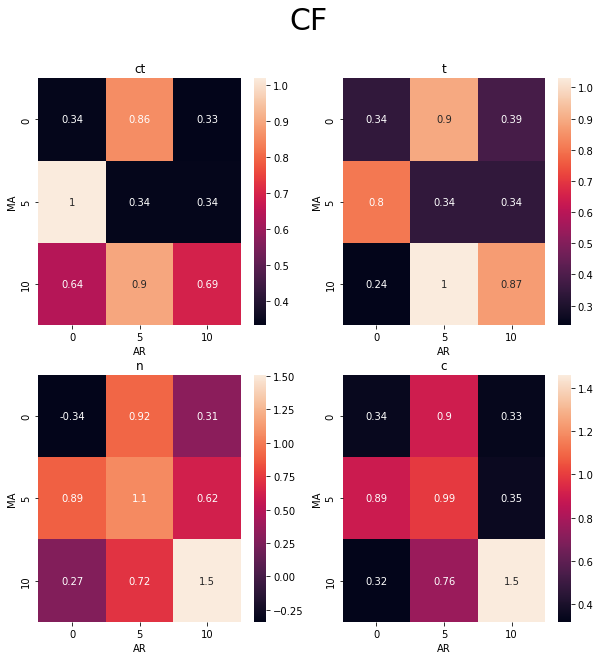

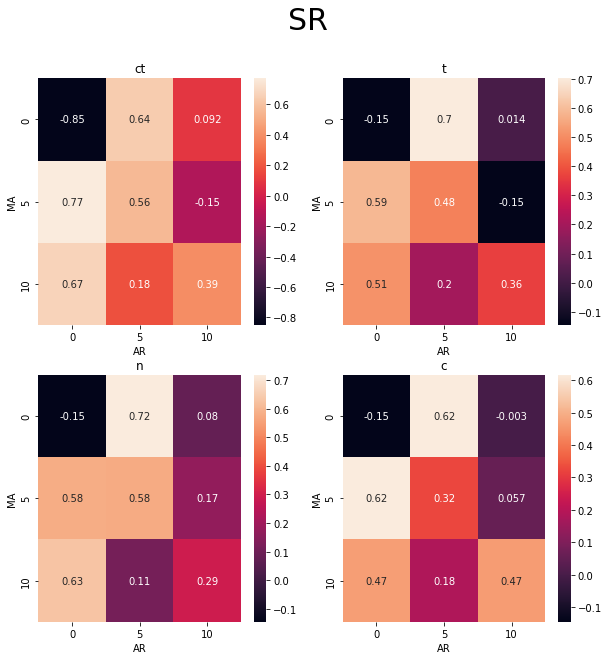

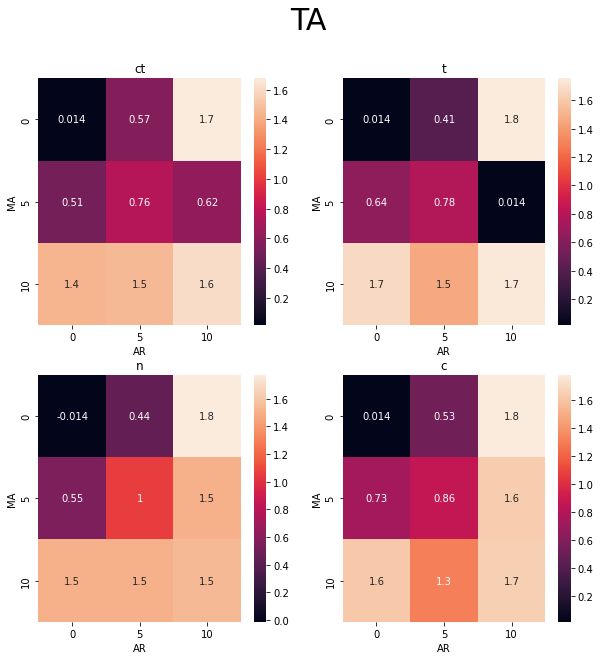

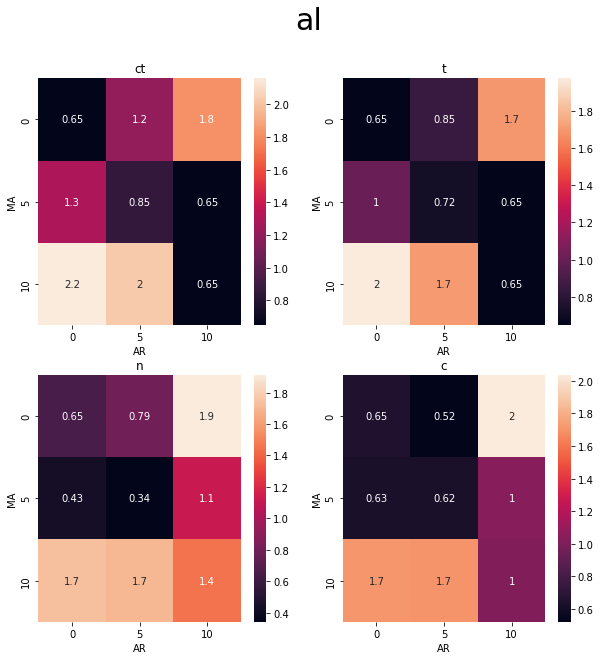

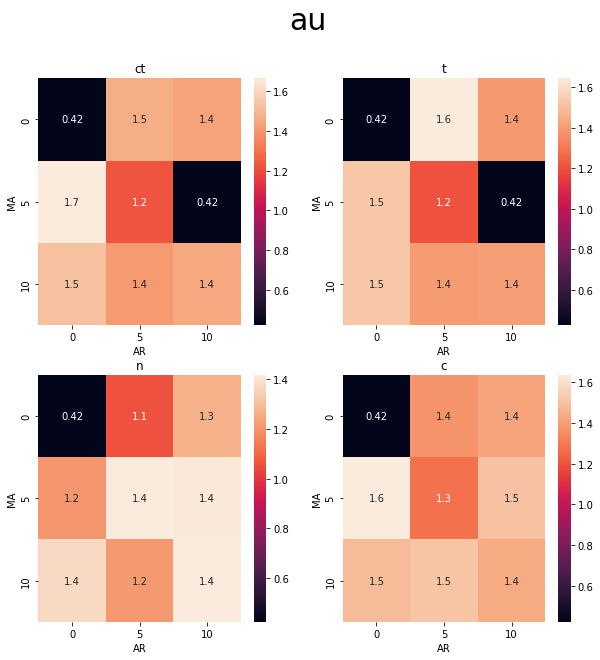

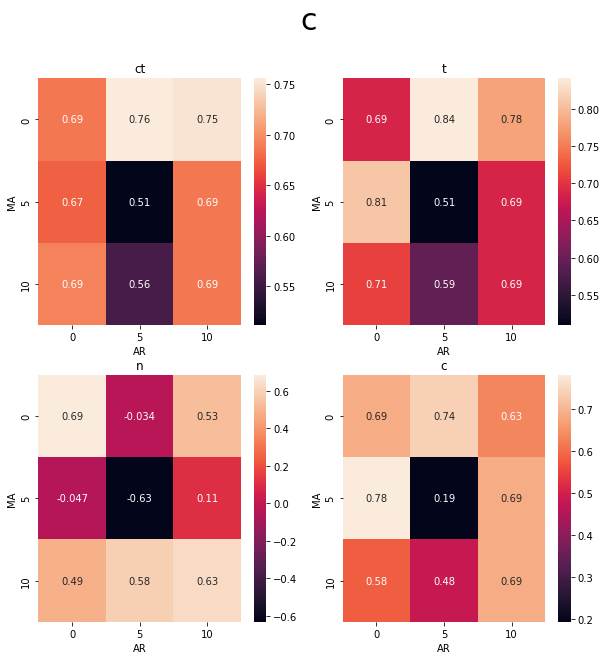

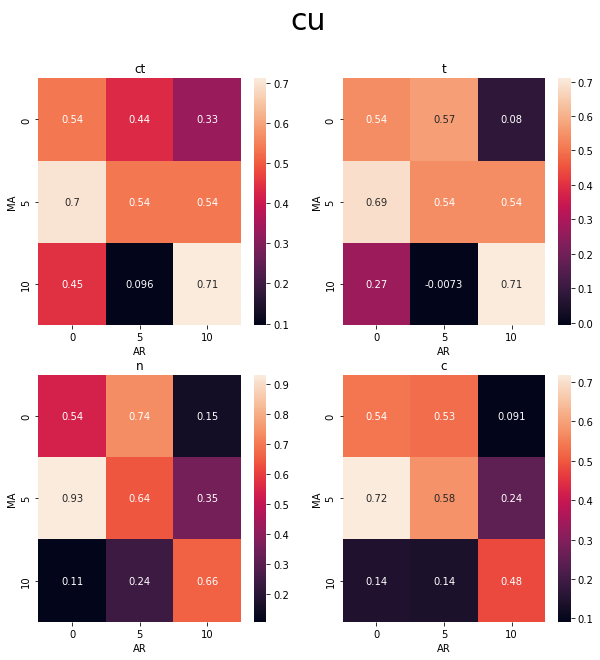

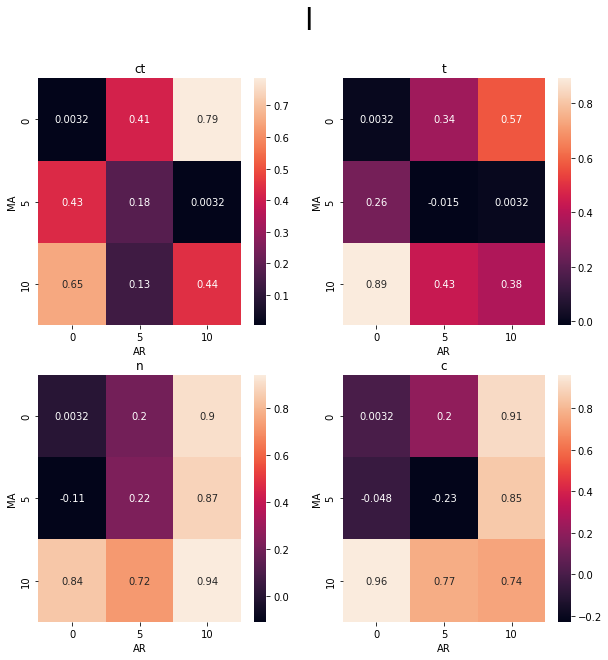

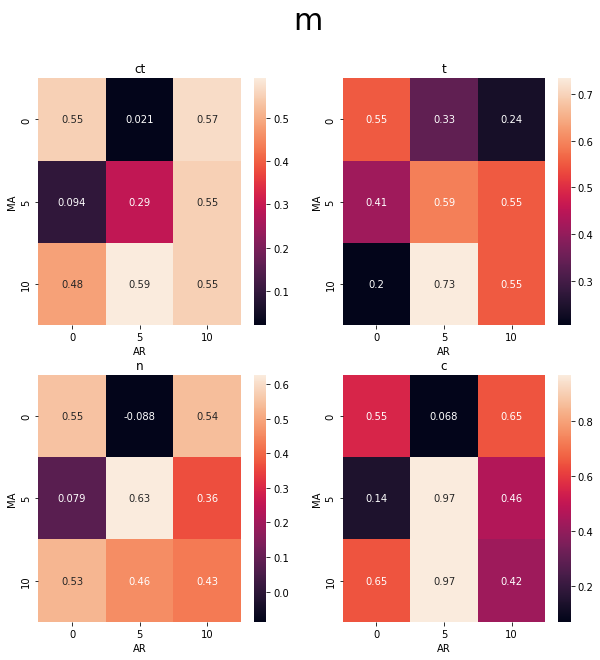

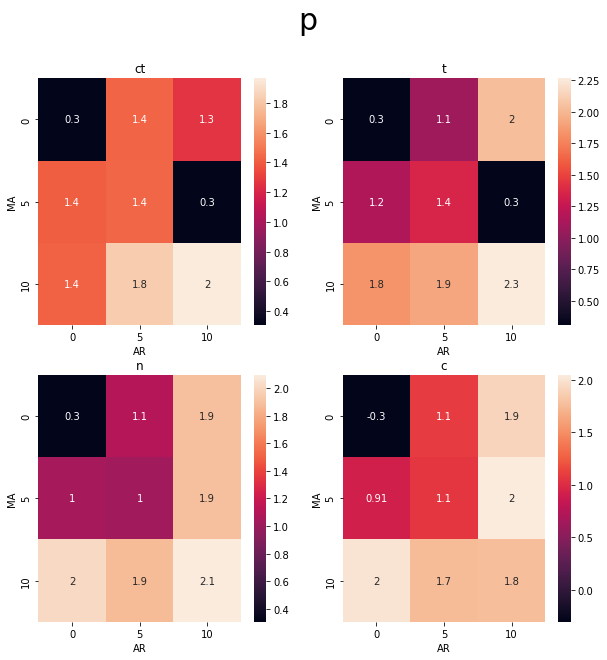

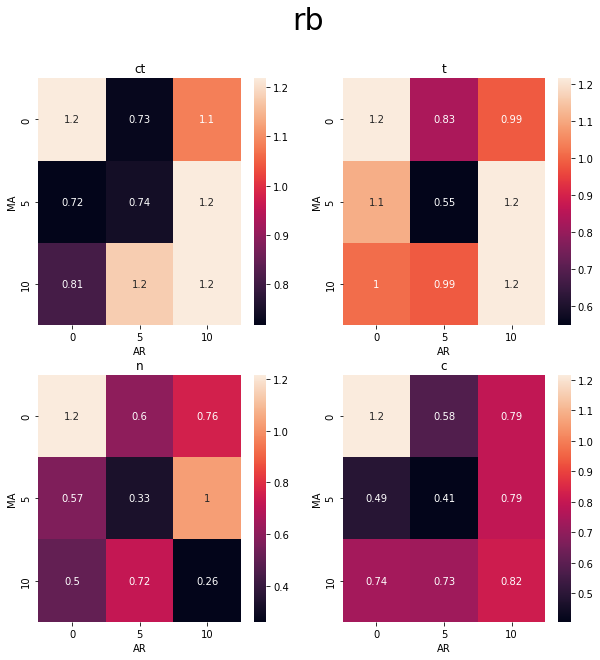

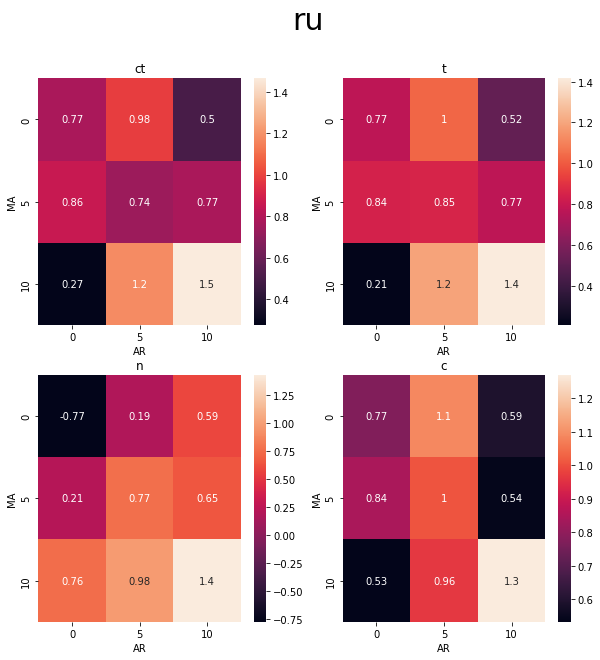

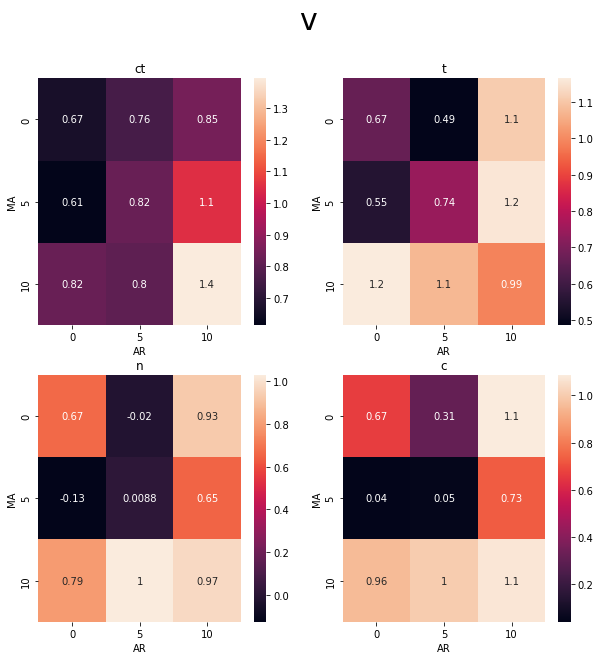

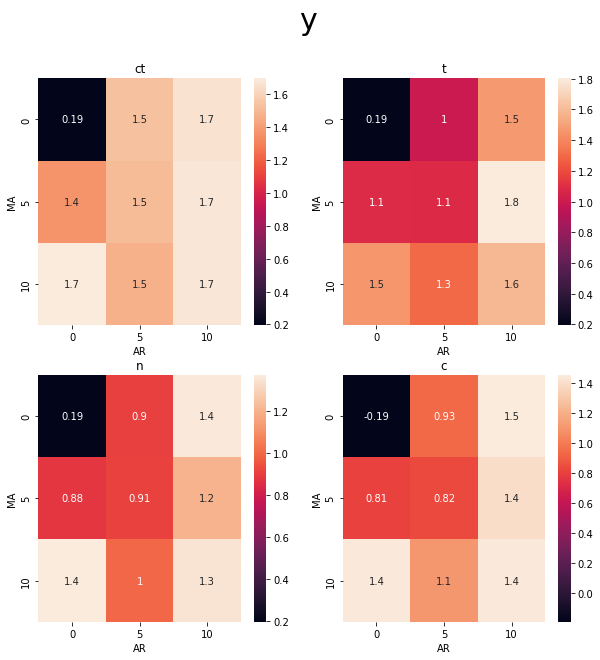

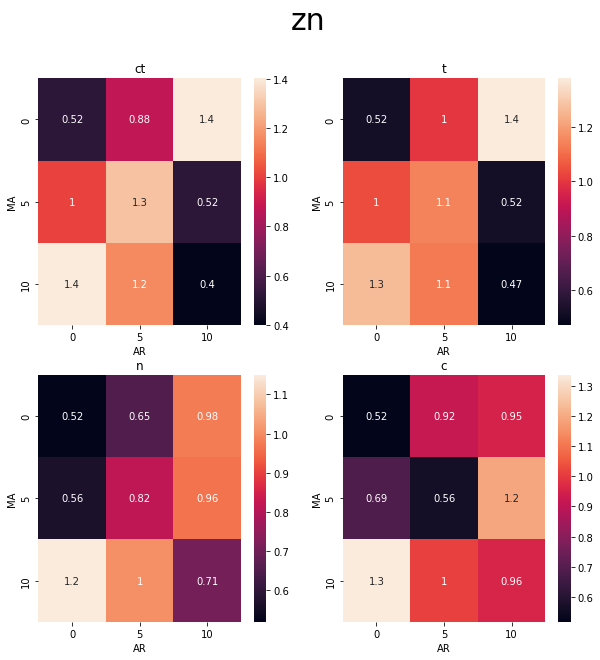

In [56]:
for col in actual_returns.columns:
    col_data = [i for i in arima_perf if i[0] == col]
    fig, ax = plt.subplots(2,2,figsize=(10, 10))
    for idx, trend in enumerate(('ct', 't', 'n', 'c')):
        x = int(idx / 2)
        y = idx % 2
        trend_data = [i for i in col_data if i[3] == trend]
        df = pd.DataFrame(index=range(0, 11, 5), columns=range(0, 11, 5))
        df.index.name='MA'
        df.columns.name="AR"
        for i in trend_data:
            df[i[1]].loc[i[2]] = i[4]
        df = df.astype(float)
        sns.heatmap(data=df, ax=ax[x][y], annot=True)
        ax[x][y].set_title(trend)
    fig.suptitle(col, fontsize=30)
    plt.savefig("w4Heatmap/" + col + '.png')